In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


load audio file


In [ ]:
import librosa
audio_path = '/content/drive/MyDrive/audio dataset/Actor_01/03-01-01-01-01-01-01.wav'
x,sr = librosa.load(audio_path)

listen audio file

In [ ]:
import IPython.display as ipd
ipd.Audio(audio_path)

plot the wave form

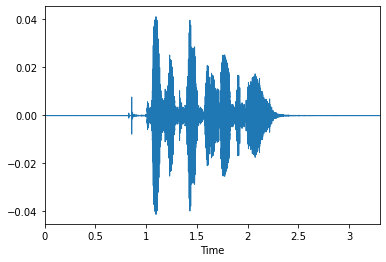

In [ ]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display
plt.figure()
librosa.display.waveplot(x,sr)

plot the spectograph

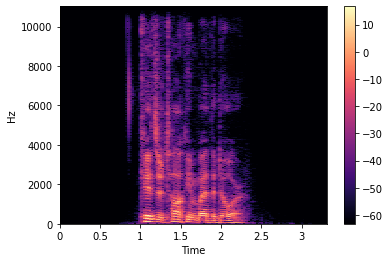

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure()
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

feature extraction(MFCC)


(20, 143)


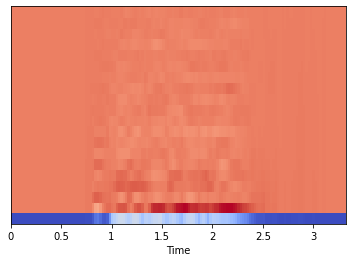

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [ ]:
import os
import numpy as np
path = '/content/drive/My Drive/audio dataset'
a = []
for subdir, dirs, files in os.walk(path):
  for file in files:
    try:
      x,sr = librosa.load(os.path.join(subdir,file),res_type='kaiser_fast')
      mfccs = np.mean(librosa.feature.mfcc(y=x,sr=sr,n_mfcc=40).T,axis = 0)
      file = int(file[7:8])-1
      arr = mfccs,file
      a.append(arr)
    except ValueError:
      continue

In [ ]:
x, y = zip(*a)
x = np.asarray(x)
y = np.asarray(y)
x.shape, y.shape

((1440, 40), (1440,))

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [ ]:
x_train_new = np.expand_dims(x_train,axis=2)
x_test_new = np.expand_dims(x_test,axis=2)
x_train_new.shape, x_test_new.shape

((1152, 40, 1), (288, 40, 1))

LSTM

In [ ]:
import tensorflow as tf
import keras
model = tf.keras.models.Sequential([tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.LSTM(units = 256, dropout=0.1,recurrent_dropout=0.2,activation='tanh',input_shape=(40,1),return_sequences=True),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64,activation='relu'),
                             tf.keras.layers.Dense(8, activation='softmax')])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (32, 40, 1)               4         
_________________________________________________________________
lstm_4 (LSTM)                (32, 40, 256)             264192    
_________________________________________________________________
flatten_2 (Flatten)          (32, 10240)               0         
_________________________________________________________________
dense_4 (Dense)              (32, 64)                  655424    
_________________________________________________________________
dense_5 (Dense)              (32, 8)                   520       
Total params: 920,140
Trainable params: 920,138
Non-trainable params: 2
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


In [ ]:
model_history = model.fit(x_train_new,y_train,batch_size=32,epochs=300,validation_data=(x_test_new,y_test))

Epoch 1/300
36/36 [==============================] - 12s 260ms/step - loss: 2.0696 - accuracy: 0.1406 - val_loss: 2.0743 - val_accuracy: 0.1528
Epoch 2/300
36/36 [==============================] - 9s 253ms/step - loss: 2.4976 - accuracy: 0.2075 - val_loss: 2.0019 - val_accuracy: 0.1910
Epoch 3/300
36/36 [==============================] - 9s 250ms/step - loss: 1.9717 - accuracy: 0.2023 - val_loss: 1.8914 - val_accuracy: 0.2500
Epoch 4/300
36/36 [==============================] - 9s 251ms/step - loss: 1.9545 - accuracy: 0.2300 - val_loss: 1.9063 - val_accuracy: 0.2292
Epoch 5/300
36/36 [==============================] - 9s 252ms/step - loss: 1.9384 - accuracy: 0.2431 - val_loss: 1.9923 - val_accuracy: 0.1944
Epoch 6/300
36/36 [==============================] - 9s 252ms/step - loss: 1.9062 - accuracy: 0.2474 - val_loss: 1.8911 - val_accuracy: 0.2222
Epoch 7/300
36/36 [==============================] - 9s 252ms/step - loss: 1.8850 - accuracy: 0.2561 - val_loss: 1.8369 - val_accuracy: 0.291

In [ ]:
model.evaluate(x_test_new,y_test)

9/9 [==============================] - 0s 33ms/step - loss: 1.3868 - accuracy: 0.6806


[1.3867992162704468, 0.6805555820465088]

Text(0.5, 0, 'epochs')

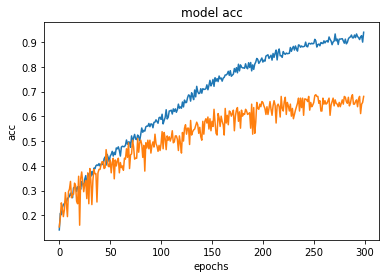

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epochs')


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predictions = model.predict_classes(x_test_new)
new_y_test = y_test.astype(int)
matrix = confusion_matrix(new_y_test, predictions)
print(classification_report(new_y_test, predictions))
print(matrix)

              precision    recall  f1-score   support

           0       0.63      0.60      0.62        20
           1       0.89      0.78      0.83        41
           2       0.66      0.53      0.59        43
           3       0.52      0.36      0.43        36
           4       0.70      0.81      0.75        32
           5       0.70      0.80      0.75        41
           6       0.64      0.75      0.69        40
           7       0.64      0.77      0.70        35

    accuracy                           0.68       288
   macro avg       0.67      0.68      0.67       288
weighted avg       0.68      0.68      0.67       288

[[12  2  1  4  0  0  1  0]
 [ 2 32  1  4  0  2  0  0]
 [ 1  0 23  0  6  4  3  6]
 [ 1  1  5 13  0  4  5  7]
 [ 0  0  0  1 26  1  2  2]
 [ 1  0  1  1  3 33  2  0]
 [ 2  1  2  1  2  2 30  0]
 [ 0  0  2  1  0  1  4 27]]
